---
layout: default
title: "System design - Error for skewed classes"
categories: design
permalink: /ML17/
order: 17
comments: true
---

In [27]:
%pylab --no-import-all inline
import pandas as pd
from scipy.stats import hmean

Populating the interactive namespace from numpy and matplotlib


# Error metrics for skewed classes
Of particular importance is correctly evaluating a learning algorithm wen classes are unbalanced (skewed)

Consider a problem where we have to tell if patients have or don't have cancer based on a set of input features.

We train a logistic regression model $h_\theta(x)$ where $y=1$ means that the patient has cancer, $y=0$ means that he/she doesn't.

We then find that the learning algorithm has $1\%$ error on the test set, in other words it outputs $99\%$ of correct diagnoses.

This may look impressive at a first glance but it doesn't anymore if we add a new piece of information: only $0.50\%$ of patients have cancer.

This means that a non-learning algorithm that always outputs $0$ will have $0.50\%$ error.

When one class in our dataset is much more abundant than the other(s) we have a case of dataset unbalance and we say that the classes are skewed. In this cases using classification error may lead to false deductions and is in general a good practice.

## Precision/Recall
When we are dealing with skewed classes we can use the couple of metrics **precision** and **recall**.

These metrics comes from the count of correct and incorrect classification of a learning algorithm on a test set. For the case of our cancer classifier (and for all binary classifiers) classifications will fall in one of four cases, summarized in the **confusion matrix**.

In [4]:
cm = pd.DataFrame([['True positive', 'False positive'], ['False negative', 'True negative']])
cm.index = pd.MultiIndex.from_product([['Predicted class'], cm.index[::-1]])
cm.columns = pd.MultiIndex.from_product([['Actual class'], cm.columns[::-1]])
cm.style.set_caption('Scheme of the contingency table for the binary case, called a confusion matrix')

Starting from this tool we can compute precision and recall:

### Precision
Precision answer the question: how many of the selected cases are relevant? To apply it to the cancer classifier it would be: Of all the patients for which $y=1$, what fraction actually has cancer? It is calculated as:

$$
\frac{\text{#True positives}}{\text{#Predicted positives}} = \frac{\text{#True positives}}{\text{#True positives} + \text{#False positives}}
$$

### Recall
Recall answer the question: how many of the relevant cases are selected? To apply it to the cancer classifier it would be: Of all the patients that actually have cancer, what fraction did we correctly detect?

$$
\frac{\text{#True positives}}{\text{#Actual positives}} = \frac{\text{#True positives}}{\text{#True positives} + \text{#False negatives}}
$$

### Trading off precision for recall
Let's say that we have trained a logistic regression algorithm $0 \geq h_\theta(x) \geq 1$ and we predict:

$$
y=
\begin{cases}
1 \quad \text{if } & h_\theta(x) \geq 0.5 \\
0 \quad \text{if } & h_\theta(x) < 0.5
\end{cases}
$$

Since telling a patient that he/she has cancer may cause a great chock in him/her, we want to give this news only if we are very confident of the prediction. So we may want to increase the threshold:

$$
y=
\begin{cases}
1 \quad \text{if } & h_\theta(x) \geq 0.9 \\
0 \quad \text{if } & h_\theta(x) < 0.9
\end{cases}
$$

This way we will attain higher precision but lower recall. However now we want to avoid missing to many cases of actual cancer, in this case we may want to lower the threshold:

$$
y=
\begin{cases}
1 \quad \text{if } & h_\theta(x) \geq 0.3 \\
0 \quad \text{if } & h_\theta(x) < 0.3
\end{cases}
$$

And we will attain higher recall but lower precision.

In general by lowering the threshold we will trade off precision for recall and if we were to plot recall and precision for a number of possible threshold values we would have something like <a href="#prerec">the figure below</a>:

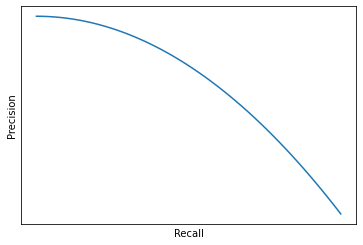

In [16]:
fig, ax = plt.subplots()
ax.plot(-(np.linspace(0, 1)**2))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision');

<i id="prerec">An ideal precision-recall curve for decreasing values of threshold (lef-to-right) applied to a logistic regression output scores compared to the actual classes.</i>

### A single metric F1-Score
Precision and recall are reliable metrics that complement each other in telling the performance of a learning algorithm. But how do we compare precision and recall? 

In the table below we have the values of precision and recall for three versions of an algorithm, and we would like to have a single number to compare the performance between them.

In [21]:
df = pd.DataFrame(zip(*[[0.5, 0.7, 0.02], [0.4, 0.1, 1.0]]), columns=['Precision', 'Recall'], index=['Algorithm 1', 'Algorithm 2', 'Algorithm 3'])
df

,Precision,Recall
Algorithm 1,0.50,0.4
Algorithm 2,0.70,0.1
Algorithm 3,0.02,1.0


We could simply take the average of precision and recall $\left(\frac{P+R}{2}\right)$, but this would not be a good strategy for extremes values of the scores. Suppose we have an algorithm predicting $y=1$ all the time (like algorithm 3), it would have very low precision but that would be balanced by a very high recall and it would come out as the best of the three algorithms.

In [26]:
df = df.assign(Average=df.mean(axis=1))
df

,Precision,Recall,Average
Algorithm 1,0.50,0.4,0.45
Algorithm 2,0.70,0.1,0.40
Algorithm 3,0.02,1.0,0.51


A different way to combine precision and recall is the $F_1$ Score is the harmonic mean between precision and recall $\left(2\frac{PR}{P+R}\right)$ and it's very sensitive to extreme values of precision and recall so that if either one of them is $\approx 0$, also $F_1$ Score will be $\approx 0$

In [32]:
df.assign(**{'$F_1$ Score': hmean(df.iloc[:, :-1], axis=1).round(3)})

,Precision,Recall,Average,$F_1$ Score
Algorithm 1,0.50,0.4,0.45,0.444
Algorithm 2,0.70,0.1,0.40,0.175
Algorithm 3,0.02,1.0,0.51,0.039


When measuring performance of a learning algorithm at different thresholds, you should use the **cross validation set** to pick the threshold that maximizes $F_1$ Score (if that's the optimization metric of your choice).